In [32]:
## Import data and produce outputs
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm
import seaborn as sns
from matplotlib import pyplot as plt
## Read in the Annual Enterprise Survey data
df = pd.read_csv('aes-2015-csv.csv')
#### Add your code here ####

### Checking and cleaning data

In [21]:
# the value column is string type and must be changed to integer.
df.Value = pd.to_numeric(df.Value, errors='coerce')
df = df.dropna(subset=['Value'])
df.Value = df.Value.astype(int)
# Changing year column to string format. I made the decision to treat Year column as categorical variable.
df['Year']=df['Year'].astype(str)
# check again whether Value column is transformed to integer.
print(len(df),df.isnull().values.any())
print(df.describe())

14677 False
              Value
count  1.467700e+04
mean   2.655422e+04
std    2.402043e+05
min   -1.313000e+05
25%    2.500000e+01
50%    2.570000e+02
75%    2.643000e+03
max    9.479400e+06


## Part A - Calculation of mean, max, and min of Value column, filtering for Total income 

In [22]:
#filtering entry rows to only Total income variable name
df=df[df.Variable_name=='Total income']
print(len(df))
# description of Value, mean, max, and min value of Total income. 
print('Value mean=', round(df.Value.describe().mean(),2))
print('Value max=', round(df.Value.describe().max(),2))
print('Value min=', round(df.Value.describe().min(),2))

417
Value mean= 84404.7
Value max= 590050.0
Value min= 417.0


# Part B- Linear regression
# the solution is wrong as the data is a panel data type.
## First, a hausman test must be perform to check whether fixed effect or random effect must be used.
Then, the interpretation must be along with fixed-effect or random-effect linear regression.

## Data cleaning 

In [33]:
#importing the table
df = pd.read_csv('aes-2015-csv.csv')
# the value column is string type and must be changed to integer.
df.Value = pd.to_numeric(df.Value, errors='coerce')
df = df.dropna(subset=['Value'])
df.Value = df.Value.astype(int)

# The Year is integer type which I decided to transform it to string.
df['Year']=df['Year'].astype(str)

# pivoting data to extract variables
df=pd.pivot_table(df,index=["Industry_code_NZSIOC",'Year'],columns=['Variable_name'], values='Value')
df=df.reset_index(level=['Year'])

### Dropping columns with more than 60% data missing. Filling the other null values by average of each column.
df=df.drop(['Margin on sales of goods for resale',
            'Salaries and wages to self employed commission agents','Sales of goods and services',
           'Sales, government funding, grants and subsidies',
           'Surplus per employee count(3)'],axis=1)
df=df.fillna(df.mean())

In [933]:
df.to_csv('cleaned version.csv')

## Feature engineering

##### Literature review in accounting and vriables that influence Total income of businesses shows that ['Total assets', 'Return on total assets', 'Quick ratio','Leverage ratio'] can be selected for independent variables.
##### Firm size is calculated as logarithm of Fixed tangible assets.
##### Productivity of industry are obtained from Return on total assets.
##### Liquidity of industry is obtained from  Quick ratio
##### Leverage ratio is calculated by (Current liability+Other liabilities)/Shareholders funds or owners equity
##### (Variables such as [ 'Surplus before income tax','Total expenditure'] are either Multicollinear or conceptually, they are not influencing the Total income. I even did a panel study to append a new column of Last year income. However, this variables is not direct variable that influence the Total income.


In [34]:
# calculation of total Liability
df['Liability']=df['Current liabilities']+df['Other liabilities']

# calculation of leverage ratio = Liability/Shareholders funds or owners equity
df['Leverage ratio']=df['Liability']/df['Shareholders funds or owners equity']

# Logarithmic of total asset
df['Total assets']=np.log(df['Total assets'])

#resetting index
df=df.reset_index()

## Linear regression pipeline

In [35]:
# selecting below variables
inputData=df[['Total assets',  'Quick ratio','Leverage ratio','Return on total assets']]  #
# inputData=df[['Return on total assets']]  #
outputData=np.log(df['Total income'])
# scaling the variables
# Get column names first
names = inputData.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(inputData)
scaled_df = pd.DataFrame(scaled_df, columns=names)
model_1=LinearRegression()
model_1.fit(scaled_df,outputData)
coefficients=pd.DataFrame({'name':list(scaled_df),'value':model_1.coef_})
print(coefficients)
print('Mean squared error:', np.mean((model_1.predict(scaled_df) - outputData) ** 2))
print('R²:',model_1.score(scaled_df, outputData))

                     name     value
0            Total assets  1.044464
1             Quick ratio -0.101341
2          Leverage ratio -0.047480
3  Return on total assets  0.203972
Mean squared error: 0.4276581200727061
R²: 0.7078268887694553


## ANOVA

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
outputData=np.log(df[['Total income']])
inputData=scaled_df[['Total assets',  'Quick ratio','Leverage ratio','Return on total assets']]
moore_lm = ols('outputData ~ inputData',
                 data=scaled_df).fit()
table = sm.stats.anova_lm(moore_lm) # ANOVA DataFrame
print('\nANOVA results' )
print(table)
print('-------------------------------------------------------------------------')
# print('\nModel summary' )
# print(moore_lm.summary())


ANOVA results
              df      sum_sq     mean_sq           F         PR(>F)
inputData    4.0  432.035654  108.008914  249.530729  1.226459e-108
Residual   412.0  178.333436    0.432848         NaN            NaN
-------------------------------------------------------------------------


#####  the F statistic is equal to sum of square of model divide by total sum of squares (108.00/0.432 = 249.53) .  The distribution is F(4, 412),and the probability of observing a value greater than or equal to 249.53 is less than 0.001. The P-value for the F test statistic is is less than 0.001, providing strong evidence against the null hypothesis. This means that there is very low probability that all of the coefficients of independent variables are zero.
##### The squared multiple correlation R² = SSM/SST = 432.03/(432.03+178.33) = 0.707, indicating that 70.7% of the variability in the "Total income" variable is explained by the "Return on total assets", "Quick ratio", "Total assets", and "Leverage ratio" variables.  


# Plot of independent variable versus dependent variable

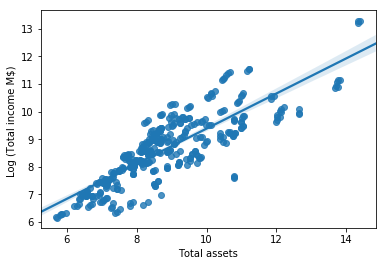

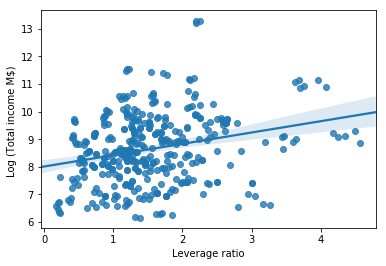

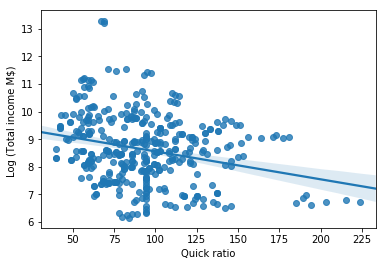

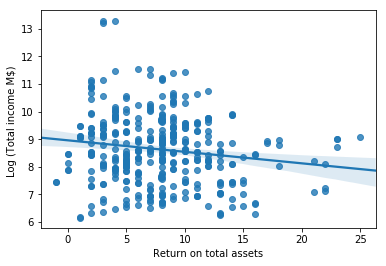

In [38]:
inputData=['Total assets',  'Leverage ratio','Quick ratio','Return on total assets']  #'Return on total assets',
# df=df[(df['Quick ratio']<200)& (df['Return on total assets']<30)&(df['Leverage ratio']<6) ] # filtering out the extreme values to show correlation more clearly.
df=df[(df['Return on total assets']>-2)& (df['Return on total assets']<30)&(df['Leverage ratio']<6)&(df['Quick ratio']<250) ] # filtering out the extreme values to show correlation more clearly.

for x in inputData:
    ax=sns.regplot(x=df[x],y=np.log(df['Total income']))
    ax.set(xlabel=x, ylabel='Log (Total income M$) ')
    plt.savefig(x+".png", dpi =150)
    plt.show()

### Plotting a diagonal correlation matrix

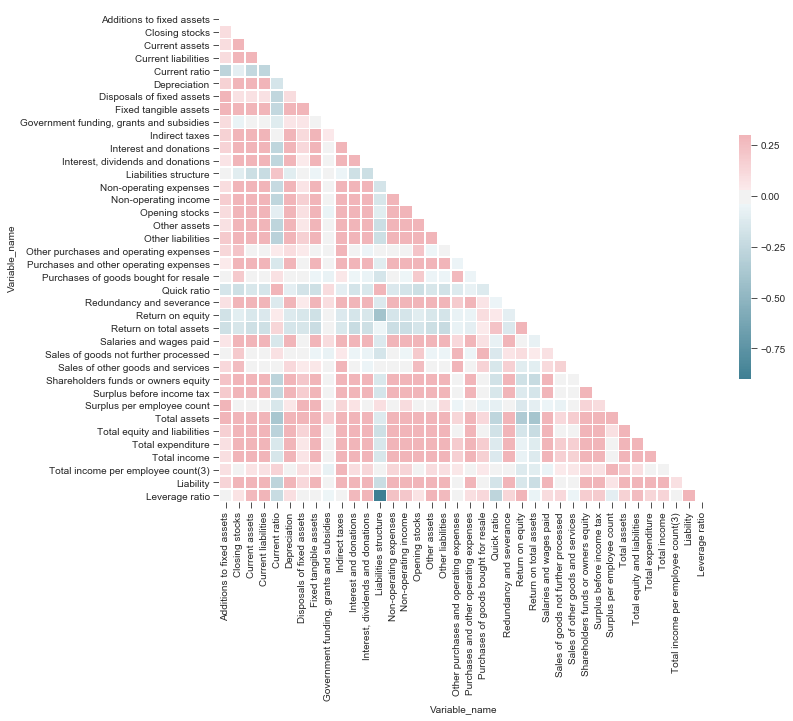

In [40]:
# Compute the correlation matrix
corr =df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()